##### <img src="mioti.png" style="height: 100px">

# Challenge S5: Modelos regresivos aplicados a series temporales

## Objetivo

El objetivo de este challenge es usar nuestro dataframe de ventas en retail y hacer un modelo para la predicción de ventas para un artículo distinto del que vimos en el worksheet.

Tendréis que explorar los datos para ver el comportamiento del artículo elegido y las peculiaridades que pueda tener.

Luego tendréis que hacer un modelo que pueda predecir las ventas de este artículo usando todo lo aprendido anteriormente, probando distintos modelos, hiperparametrizándolos y por último añadiendo todas las variables sintéticas que veáis convenientes para que el modelo aprenda mejor del comportamiento de las unidades vendidas del producto.

## 1. Configuración del entorno

Cargamos los paquetes que vamos a utilizar en la sesión.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from timeit import default_timer

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")


## 2. Carga de los datos, filtrado de nuestro artículo y visualización de los datos
 



**Carga el dataframe**

In [2]:
dataRetail = pd.read_csv('Dataframe_Retail.csv', delimiter=',')
print(dataRetail['Referencia'].unique())

['Cerveza tercio' 'Baguetes 2 unidades' 'Aceite de oliva virgen extra 5 l'
 'Bolsa naranjas 2Kg.' 'Mandarina' 'Melo  OR' 'Jamón reserva'
 'Naranja en cajas' 'Pack de plátanos'
 'MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)' 'Tomate jugoso al peso'
 'Filetes de salmón' 'Sepia' 'Fresa premium 500gr']


**Usa una máscara para filtrar el artículo sobre el que queremos realizar las predicciones**

In [3]:
dataSku = dataRetail[dataRetail['Referencia']=='Bolsa naranjas 2Kg.'].copy()
dataSku['Fecha'] = pd.to_datetime(dataSku['Fecha'], format='%Y-%m-%d')
dataSku=dataSku.set_index('Fecha')

In [4]:
dataSku

,Referencia,Unidades,Ventas
Fecha,,,
2017-01-02,Bolsa naranjas 2Kg.,1118.0,1889.420064
2017-01-03,Bolsa naranjas 2Kg.,1216.0,2055.040070
2017-01-04,Bolsa naranjas 2Kg.,1276.0,2156.440073
2017-01-05,Bolsa naranjas 2Kg.,1608.0,2717.520092
2017-01-06,Bolsa naranjas 2Kg.,3.0,5.070000
...,...,...,...
2019-05-14,Bolsa naranjas 2Kg.,747.0,1602.950056
2019-05-15,Bolsa naranjas 2Kg.,707.0,1531.310053
2019-05-16,Bolsa naranjas 2Kg.,727.0,1574.430055


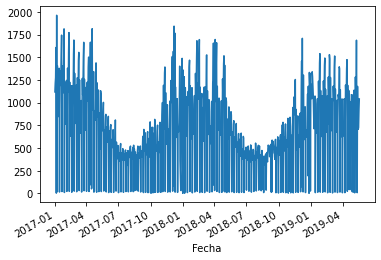

In [5]:
dataSku.loc[:,'Unidades'].plot();

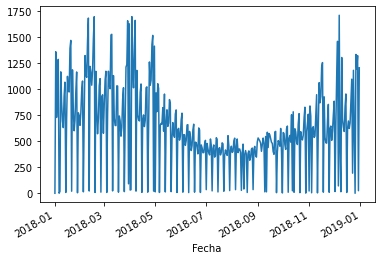

In [6]:
dataSku.loc['2018-01-01':'2018-12-31','Unidades'].plot();

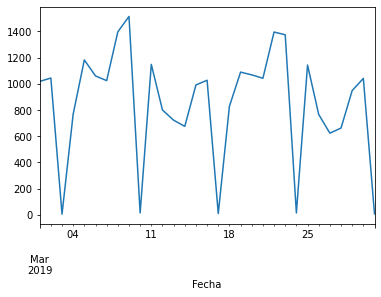

In [7]:
dataSku.loc['2019-03-01':'2019-03-31','Unidades'].plot();

** Ya que hemos cogido un producto que tiene huecos vamos a hacer una limpieza del dataframe ya que esos huecos originarían errores más tarde**

In [8]:
fechaMin = dataSku.index.min()
print(fechaMin)

2017-01-02 00:00:00


In [9]:
fechaMax = dataSku.index.max()
print(fechaMax)

2019-05-18 00:00:00


In [10]:
dateRange = pd.date_range(start=fechaMin, end=fechaMax,freq='d')
dataSku = dataSku.reindex(dateRange)
dataSku['Unidades']=dataSku['Unidades'].fillna(value=0)
dataSku['Ventas']=dataSku['Ventas'].fillna(value=0)
dataSku['Referencia']=dataSku['Referencia'].fillna(method='ffill')
dataSku=dataSku.reset_index()
dataSku=dataSku.rename(columns={'index':'Fecha Format'})
#dataSku['OffsetDays']=dataSku['OffsetDays'].astype(int)
dataSku['OffsetDays'] = dataSku.index

In [11]:
dataSku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Fecha Format  867 non-null    datetime64[ns]
 1   Referencia    867 non-null    object        
 2   Unidades      867 non-null    float64       
 3   Ventas        867 non-null    float64       
 4   OffsetDays    867 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 34.0+ KB


In [12]:
dataSku.tail(60)

,Fecha Format,Referencia,Unidades,Ventas,OffsetDays
807,2019-03-20,Bolsa naranjas 2Kg.,1068.000,1805.420060,807
808,2019-03-21,Bolsa naranjas 2Kg.,1042.000,1760.980060,808
809,2019-03-22,Bolsa naranjas 2Kg.,1394.885,2357.360079,809
810,2019-03-23,Bolsa naranjas 2Kg.,1374.000,2322.060079,810
811,2019-03-24,Bolsa naranjas 2Kg.,14.000,23.660001,811
812,2019-03-25,Bolsa naranjas 2Kg.,1143.000,1931.670065,812
813,2019-03-26,Bolsa naranjas 2Kg.,766.000,1636.200057,813
814,2019-03-27,Bolsa naranjas 2Kg.,623.000,1349.210047,814
815,2019-03-28,Bolsa naranjas 2Kg.,662.000,1435.620048,815
816,2019-03-29,Bolsa naranjas 2Kg.,948.000,2056.300070,816


In [13]:
dataSku[dataSku['Unidades']==0]

,Fecha Format,Referencia,Unidades,Ventas,OffsetDays
357,2017-12-25,Bolsa naranjas 2Kg.,0.0,0.0,357
608,2018-09-02,Bolsa naranjas 2Kg.,0.0,0.0,608
612,2018-09-06,Bolsa naranjas 2Kg.,0.0,0.0,612
622,2018-09-16,Bolsa naranjas 2Kg.,0.0,0.0,622
722,2018-12-25,Bolsa naranjas 2Kg.,0.0,0.0,722
729,2019-01-01,Bolsa naranjas 2Kg.,0.0,0.0,729
734,2019-01-06,Bolsa naranjas 2Kg.,0.0,0.0,734


<AxesSubplot:>

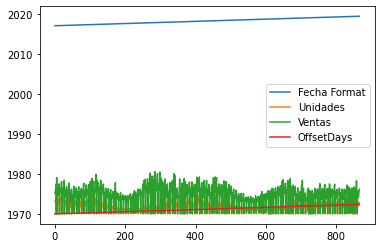

In [14]:
dataSku.plot()

## 3. Prueba de la predicción sobre nuestras unidades vendidas con distintos modelos

** Con la función de evaluación puedes probar el funcionamiento de distintos modelos**

In [15]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))
def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    for day in range(777,867):#Modificar este data range en función de la longitud final del dataframe que nos salga y necesitemos para la prevsion
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Unidades'], axis=1), val.drop(['Unidades'], axis=1)
       
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Unidades'].values, val['Unidades'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted=xPredicted + [day]
        yPredicted=yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = rmsle(yts, p)
#         print('Month %d - Error %.5f' % (day, error))
        mean_error.append(error)

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Sold units predicted': yPredicted,
         'Sold units actually spotted': ySpotted
        },index=xPredicted)
    prediction.plot()
    plt.show();

** Elige el modelo que más te haya gustado o mejor haya funcionado e hiperparametrizalo si quieres**

In [16]:
norma=True
dataSku_simple = dataSku[['OffsetDays','Unidades']].copy()
dataSku_simple.info()
#calculoEvaluacionModelo(RandomForestRegressor(n_estimators=20, random_state=42),dataSku_simple,norma)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   OffsetDays  867 non-null    int64  
 1   Unidades    867 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 13.7 KB


In [17]:
# Creamos una lista con los distintos modelos que queremos utilizar
# Como esta parte es sin ajustar parámetros los ejecutamos con los que vengan por defecto.
models = []
models.append(('LR',  LinearRegression())) #Regresión Lineal
models.append(('SVM', SVR())) # Máquina Vector Soporte
models.append(('GBR', GradientBoostingRegressor(random_state=42))) #GBoostingRegresor
models.append(('RFR', RandomForestRegressor(random_state=42))) #RandomForest
models.append(('KNR', KNeighborsRegressor())) #KNR
models.append(('RAN',  RANSACRegressor(random_state=42))) #RANSAC
models.append(('MLP', MLPRegressor(random_state=42)))# Red neuronal MLP

Predicción Modelo :LR
Mean Error = 1.01569


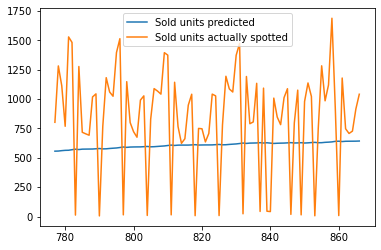

Predicción Modelo :SVM
Mean Error = 0.93968


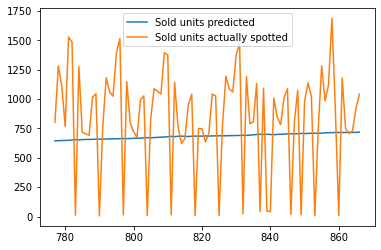

Predicción Modelo :GBR
Mean Error = 1.15046


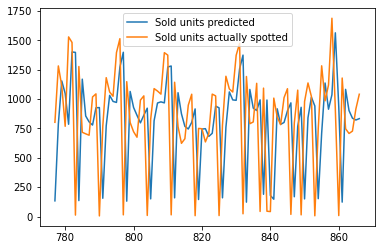

Predicción Modelo :RFR
Mean Error = 1.00315


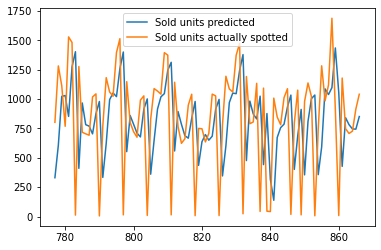

Predicción Modelo :KNR
Mean Error = 0.94478


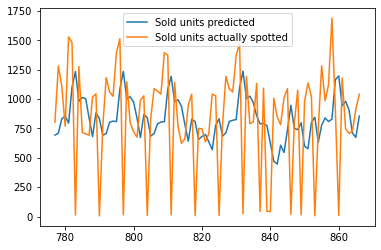

Predicción Modelo :RAN
Mean Error = 1.05972


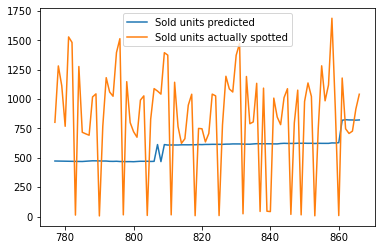

Predicción Modelo :MLP
Mean Error = 1.92079


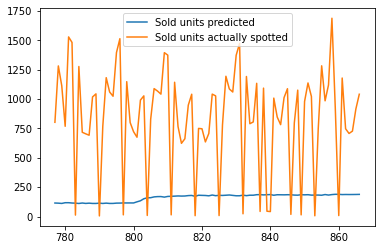

In [18]:
for index,model in enumerate(models):
    print('Predicción Modelo :'+model[0])
    calculoEvaluacionModelo(model[1],dataSku_simple,norma)
  

* Procedemos a realizar la Hiperparametrización.

In [19]:
dataset_X=dataSku_simple
dataset_X=dataset_X.drop(['Unidades'], axis=1)
dataset_y=dataSku_simple['Unidades']


In [20]:
# Como técnica recomendable aunque algunos algoritmos son más o menos sensibles a las distintas magnitudes
# escalamos el dataset_X con el StandardScaler. Aplica una normalización por columnas.

scale = StandardScaler().fit(dataset_X)
dataset_X_scaled = scale.transform(dataset_X)
#Visualizamos como han quedado los valores
dataset_X_scaled[:5]


array([[-1.73005421],
       [-1.7260587 ],
       [-1.72206319],
       [-1.71806769],
       [-1.71407218]])

In [21]:
# Procedemos a hacer la partición en parte train y test.
# Como el dataset está muy desbalanceado configuramos el parámatero stratify, para que en las particiones se respete las
# proporciones. Si no lo activaramos, muy probablemente la parte de train o de test no tendrían muestras 
# de la clase minoritaria.

X_train, X_test, y_train, y_test = train_test_split(dataset_X_scaled, dataset_y, test_size=.2, random_state=42)

In [22]:
# Configuramos parámetros
params_grid_SVM = {'C': [0.001, 0.01, 0.1, 1, 10], 
               'kernel': ['linear', 'rbf', 'sigmoid'],
               }

params_grid_GBR = {'learning_rate': [0.01,0.02,0.03,0.04],
#                   'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500],
                  'max_depth'    : [4,6,8], 
                  'random_state': [42]
             }


param_grid_RFR = {'max_depth': [3, 5, 10],
                 'min_samples_split': [2, 5, 10],
                 'n_estimators' : [100,500,1000],
                 'random_state': [42]}


param_grid_KNR = {'n_neighbors': [3, 5, 11,19],
                 'weights': ['uniform','distance'],
#                  'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
                 'p': [1,2]}


params_grid_MLP = {"hidden_layer_sizes": [(1,),(50,)],
                   "activation": ["identity", "logistic", "tanh", "relu"],
                   "solver": ["lbfgs", "sgd", "adam"],
                   "alpha": [0.00005,0.0005],
                   "random_state": [42],
                   
                  }


In [23]:

models_hiper = []

models_hiper.append(('SVM', SVR(),params_grid_SVM))# Máquina Vector Soporte
models_hiper.append(('GBR', GradientBoostingRegressor(),params_grid_GBR))#GBoostingRegresor
models_hiper.append(('RFR', RandomForestRegressor(),param_grid_RFR)) #RandomForest
models_hiper.append(('KNR', KNeighborsRegressor(),param_grid_KNR)) #KNR
models_hiper.append(('MLP', MLPRegressor(random_state=42),params_grid_MLP))# Red neuronal MLP
                 

In [24]:
#Hiperparametrización. Para realizar la hiperparametrización nos vamos a basar en herramientas como GridSearchCV
#Para la hiperparametrización utilizaremos GridSearchCV con el marcador  r2. El RMSLE lo calculamos apoyandonos en la funci
#que ya venía en el notebook.

df_resultados=pd.DataFrame() # Dataframe donde iremos recogiendo tanto scores, como datos de rendimiento.
for index,model in enumerate(models_hiper):
    
    tiempo_inicial = default_timer()
    grid_cv = GridSearchCV(model[1],param_grid=model[2], n_jobs=4,scoring ='r2')
    grid_cv.fit(X_train, y_train)
    tiempo_total = default_timer()-tiempo_inicial
    y_predicted=grid_cv.predict(X_test)
    rmsle_score = rmsle(y_test, y_predicted)
    
    df_resultados.loc[index,'Modelo']=model[0]
    df_resultados.loc[index,'Best_Score_hiper'] = str(grid_cv.best_score_)
    df_resultados.loc[index,'r2_test']=grid_cv.score(X_test, y_test)
    df_resultados.loc[index,'rmsle_score']=rmsle_score
    df_resultados.loc[index,'Best_Params_hiper'] = str(grid_cv.best_params_)
    df_resultados.loc[index,'tiempo_ejecucion_hiper'] = default_timer()-tiempo_inicial
      
    print('\n')
    print('MODELO : ',model[0])
    print('Best Score : ',grid_cv.best_score_)
    print('Best Params : ',grid_cv.best_params_)
        # Lo evaluamos, datos test
    print('Score R2 parte test :',grid_cv.score(X_test, y_test))
    print('Score RMSLE :',rmsle_score)
    print('Tiempo de ejecución de GridSearchCV para ',model[0],' es : ',tiempo_total,'\n')
    



MODELO :  SVM
Best Score :  0.08382423443027007
Best Params :  {'C': 10, 'kernel': 'rbf'}
Score R2 parte test : 0.11160384926172384
Score RMSLE : 1.5488731114320222
Tiempo de ejecución de GridSearchCV para  SVM  es :  3.372882599999997 



MODELO :  GBR
Best Score :  0.11146500927985455
Best Params :  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}
Score R2 parte test : 0.15231779400939427
Score RMSLE : 1.5550063043918483
Tiempo de ejecución de GridSearchCV para  GBR  es :  9.094678099999982 



MODELO :  RFR
Best Score :  0.11274654305768757
Best Params :  {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}
Score R2 parte test : 0.17899700205210756
Score RMSLE : 1.5548079756085054
Tiempo de ejecución de GridSearchCV para  RFR  es :  50.89357709999999 



MODELO :  KNR
Best Score :  0.17107572345559996
Best Params :  {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}
Score R2 parte test : 0.1754507647096929
Score RMSLE : 

* Una vez pasados por los procesos de hiperparametrización y seleccionado el mejor parámetro vamos a seleccionar la red MLP con los párámetros {'activation': 'logistic', 'alpha': 5e-05, 'hidden_layer_sizes': (50,), 'random_state': 42, 'solver': 'lbfgs'}

In [25]:
# Creamos una lista con los distintos modelos que queremos utilizar
# Como esta parte es sin ajustar parámetros los ejecutamos con los que vengan por defecto.
models = []
models.append(('SVM', SVR(kernel='rbf', C=10))) # Máquina Vector Soporte
#{'C': 10, 'kernel': 'rbf'}

models.append(('GBR', GradientBoostingRegressor(learning_rate=0.01,max_depth=4,n_estimators=100,random_state=42))) #GBoostingRegresor
#{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'random_state': 42}

models.append(('RFR', RandomForestRegressor(max_depth=5, min_samples_split=10,n_estimators=500,random_state=42))) #RandomForest
# {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}

models.append(('KNR', KNeighborsRegressor(n_neighbors=19,p=1,weights='uniform'))) #KNR
# {'n_neighbors': 19, 'p': 1, 'weights': 'uniform'}

# Comento MLP tiene un alto coste de computación y tarda muchisismo. 
# models.append(('MLP', MLPRegressor(activation='logistic',alpha=0.00005,hidden_layer_sizes=50,solver='lbfgs',random_state=42)))# Red neuronal MLP
#{'activation': 'logistic', 'alpha': 5e-05, 'hidden_layer_sizes': (50,), 'random_state': 42, 'solver': 'lbfgs'}

Predicción Modelo :SVM
Mean Error = 0.87694


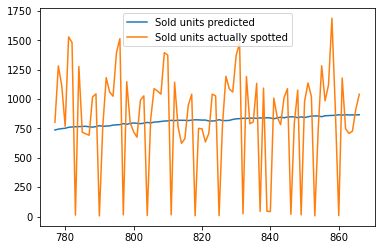

Predicción Modelo :GBR
Mean Error = 0.92984


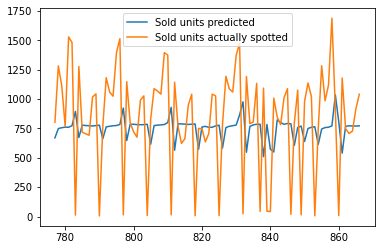

Predicción Modelo :RFR
Mean Error = 0.99150


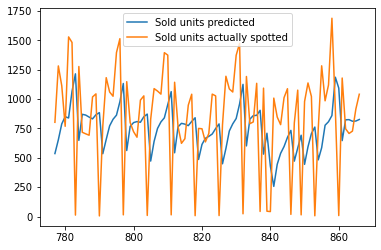

Predicción Modelo :KNR
Mean Error = 0.89006


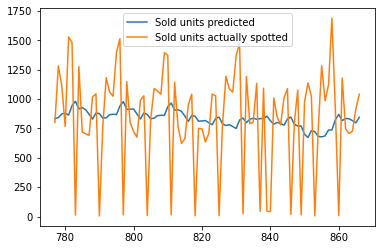

In [26]:
#Ahora con los mejores parámetros volvemos a lanzar la evaluación con calculoEvaluacionModelo
for index,model in enumerate(models):
    print('Predicción Modelo :'+model[0])
    calculoEvaluacionModelo(model[1],dataSku_simple,norma)

* Con la hiperparametrización observamos que ya hemos rebajado el error. En algunos casos solo decimas como SVM y en otros hasta 1 punto como en MLP

## 4. Complementar el dataframe con variables sintéticas

** En base a lo que hayas observado en el comportamiento de las unidades vendidas de tu referencia crea variables sintéticas que creas que ayuden al modelo a mejorar la predicción**

In [27]:
# La primera técnica que vamos a utilizar es generación de variables sintecticas utilizando dummies variables
# Para seguir reflejando esta periodicidades y dado que trabajamos con series temporales creemos que 
# es muy importante reflejar en que día se generan esas ventas.
# Para ello utilizaremos la técnica de las dummies variables.
dataSku2 = dataSku.copy()
dataSku2['Dia_semana'] = dataSku2['Fecha Format'].dt.dayofweek
dataSku2=pd.get_dummies(dataSku2,columns=['Dia_semana'])
dataSku2=dataSku2.dropna()
dataSku2


,Fecha Format,Referencia,Unidades,Ventas,OffsetDays,Dia_semana_0,Dia_semana_1,Dia_semana_2,Dia_semana_3,Dia_semana_4,Dia_semana_5,Dia_semana_6
0,2017-01-02,Bolsa naranjas 2Kg.,1118.0,1889.420064,0,1,0,0,0,0,0,0
1,2017-01-03,Bolsa naranjas 2Kg.,1216.0,2055.040070,1,0,1,0,0,0,0,0
2,2017-01-04,Bolsa naranjas 2Kg.,1276.0,2156.440073,2,0,0,1,0,0,0,0
3,2017-01-05,Bolsa naranjas 2Kg.,1608.0,2717.520092,3,0,0,0,1,0,0,0
4,2017-01-06,Bolsa naranjas 2Kg.,3.0,5.070000,4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
862,2019-05-14,Bolsa naranjas 2Kg.,747.0,1602.950056,862,0,1,0,0,0,0,0
863,2019-05-15,Bolsa naranjas 2Kg.,707.0,1531.310053,863,0,0,1,0,0,0,0
864,2019-05-16,Bolsa naranjas 2Kg.,727.0,1574.430055,864,0,0,0,1,0,0,0
865,2019-05-17,Bolsa naranjas 2Kg.,915.0,1981.690069,865,0,0,0,0,1,0,0


In [28]:
# La segunda técnica que vamos a utilizar es generación de variables sintecticas con las técnicas de lags y diferencias.
# Como observamos ciertas periodicidades semanales, calculamos la diferecnia de ventas del día anterior y los 7 anteriores
dataSku2=dataSku2[['Unidades','Ventas','OffsetDays','Dia_semana_0','Dia_semana_1','Dia_semana_2','Dia_semana_3','Dia_semana_4','Dia_semana_5','Dia_semana_6']]

dataSku2['Ventas_dif_prev1'] = dataSku2['Ventas'].diff(1)
dataSku2['Ventas_dif_prev2'] = dataSku2['Ventas'].diff(2)
dataSku2['Ventas_dif_prev3'] = dataSku2['Ventas'].diff(3)
dataSku2['Ventas_dif_prev4'] = dataSku2['Ventas'].diff(4)
dataSku2['Ventas_dif_prev5'] = dataSku2['Ventas'].diff(5)
dataSku2['Ventas_dif_prev6'] = dataSku2['Ventas'].diff(6)
dataSku2['Ventas_dif_prev7'] = dataSku2['Ventas'].diff(7)

dataSku2=dataSku2.dropna()
dataSku2

,Unidades,Ventas,OffsetDays,Dia_semana_0,Dia_semana_1,Dia_semana_2,Dia_semana_3,Dia_semana_4,Dia_semana_5,Dia_semana_6,Ventas_dif_prev1,Ventas_dif_prev2,Ventas_dif_prev3,Ventas_dif_prev4,Ventas_dif_prev5,Ventas_dif_prev6,Ventas_dif_prev7
7,1407.0,2377.830080,7,1,0,0,0,0,0,0,2350.790079,-939.640032,2372.760080,-339.690012,221.390007,322.790010,488.410016
8,1091.0,2163.890009,8,0,1,0,0,0,0,0,-213.940071,2136.850008,-1153.580103,2158.820009,-553.630083,7.449936,108.849939
9,846.0,1683.240006,9,0,0,1,0,0,0,0,-480.650003,-694.590074,1656.200005,-1634.230106,1678.170006,-1034.280086,-473.200067
10,926.0,1842.740007,10,0,0,0,1,0,0,0,159.500001,-321.150002,-535.090073,1815.700006,-1474.730105,1837.670007,-874.780084
11,1192.0,2372.080008,11,0,0,0,0,1,0,0,529.340001,688.840003,208.190000,-5.750072,2345.040007,-945.390104,2367.010008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,747.0,1602.950056,862,0,1,0,0,0,0,0,-507.459899,1588.630056,-25.949909,-1418.569880,-401.849901,-160.559906,-708.679899
863,707.0,1531.310053,863,0,0,1,0,0,0,0,-71.640003,-579.099902,1516.990054,-97.589912,-1490.209882,-473.489904,-232.199909
864,727.0,1574.430055,864,0,0,0,1,0,0,0,43.120002,-28.520001,-535.979900,1560.110055,-54.469910,-1447.089880,-430.369902
865,915.0,1981.690069,865,0,0,0,0,1,0,0,407.260014,450.380015,378.740013,-128.719886,1967.370069,352.790103,-1039.829867


Predicción Modelo :SVM
Mean Error = 0.65421


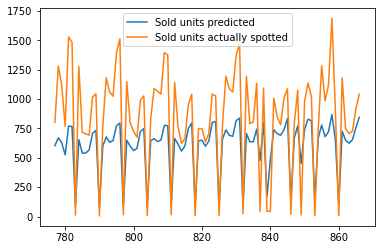

Predicción Modelo :GBR
Mean Error = 0.59795


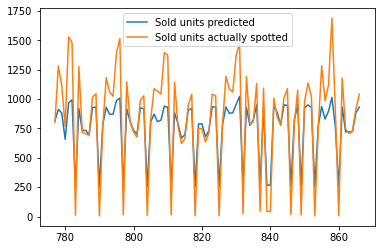

Predicción Modelo :RFR
Mean Error = 0.11596


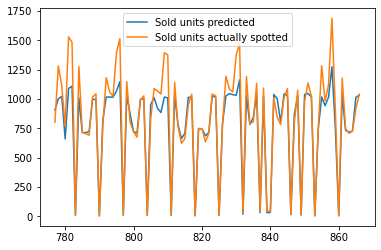

Predicción Modelo :KNR
Mean Error = 0.28718


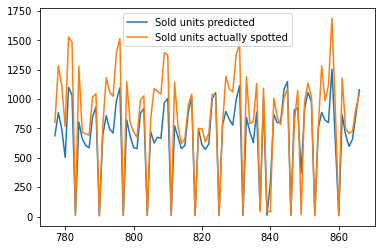

In [29]:
# Evaluamos si se mejoran las predicciones.
# Usaremos los mismos algoritmos que hemos hiperparametrizado.

for index,model in enumerate(models):
    print('Predicción Modelo :'+model[0])
    calculoEvaluacionModelo(model[1],dataSku2,norma)

* Ya han salido valores muy bajos de error, por lo que se ha mejorado mucho.
    - Por ejemplo RandomForest (RFR) ya muestra un 0,11 
    - K-vecinos (KNR) muestra 0.28

In [30]:
# Intentamos una mejora adicional incluyendo información de los meses generando dummies.
# Así también le incorporamos la diferencia e ventas de los últimos 30 días. Esto al generar 30 nan y tenerlos que borrar
# es un riesgo de overfitting devido a que estamos borrando observaciones.


In [31]:
# Por otra parte y para seguir reflejando esta periodicidads y dado que trabajamos con series temporales.
# Es muy importante reflejar en que día se generan esas ventas.
# Para ello utilizaremos la técnica de las dummies variables.

dataSku3 = dataSku.copy()
dataSku3['Mes'] = dataSku['Fecha Format'].dt.month
dataSku3['Dia_semana'] = dataSku3['Fecha Format'].dt.dayofweek

dataSku3=pd.get_dummies(dataSku3,columns=['Mes','Dia_semana'])
#Meses del año puede reflejar estacinalidad anual
dataSku3=dataSku3.dropna()
dataSku3

,Fecha Format,Referencia,Unidades,Ventas,OffsetDays,Mes_1,Mes_2,Mes_3,Mes_4,Mes_5,...,Mes_10,Mes_11,Mes_12,Dia_semana_0,Dia_semana_1,Dia_semana_2,Dia_semana_3,Dia_semana_4,Dia_semana_5,Dia_semana_6
0,2017-01-02,Bolsa naranjas 2Kg.,1118.0,1889.420064,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2017-01-03,Bolsa naranjas 2Kg.,1216.0,2055.040070,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2017-01-04,Bolsa naranjas 2Kg.,1276.0,2156.440073,2,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2017-01-05,Bolsa naranjas 2Kg.,1608.0,2717.520092,3,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2017-01-06,Bolsa naranjas 2Kg.,3.0,5.070000,4,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,2019-05-14,Bolsa naranjas 2Kg.,747.0,1602.950056,862,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
863,2019-05-15,Bolsa naranjas 2Kg.,707.0,1531.310053,863,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
864,2019-05-16,Bolsa naranjas 2Kg.,727.0,1574.430055,864,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
865,2019-05-17,Bolsa naranjas 2Kg.,915.0,1981.690069,865,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [32]:
dataSku3=dataSku3[['Unidades','Ventas','OffsetDays','Mes_1','Mes_2','Mes_3','Mes_4','Mes_5','Mes_6','Mes_7','Mes_8','Mes_9','Mes_10','Mes_11','Mes_12','Dia_semana_0','Dia_semana_1','Dia_semana_2','Dia_semana_3','Dia_semana_4','Dia_semana_5','Dia_semana_6']]
dataSku3['Ventas_dif_prev1'] = dataSku3['Ventas'].diff(1)
dataSku3['Ventas_dif_prev2'] = dataSku3['Ventas'].diff(2)
dataSku3['Ventas_dif_prev3'] = dataSku3['Ventas'].diff(3)
dataSku3['Ventas_dif_prev4'] = dataSku3['Ventas'].diff(4)
dataSku3['Ventas_dif_prev5'] = dataSku3['Ventas'].diff(5)
dataSku3['Ventas_dif_prev6'] = dataSku3['Ventas'].diff(6)
dataSku3['Ventas_dif_prev7'] = dataSku3['Ventas'].diff(7)
dataSku3['Ventas_dif_mes_ant'] = dataSku3['Ventas'].diff(30)
dataSku3=dataSku3.dropna()
dataSku3

,Unidades,Ventas,OffsetDays,Mes_1,Mes_2,Mes_3,Mes_4,Mes_5,Mes_6,Mes_7,...,Dia_semana_5,Dia_semana_6,Ventas_dif_prev1,Ventas_dif_prev2,Ventas_dif_prev3,Ventas_dif_prev4,Ventas_dif_prev5,Ventas_dif_prev6,Ventas_dif_prev7,Ventas_dif_mes_ant
30,763.0,1517.470006,30,0,1,0,0,0,0,0,...,0,0,-223.040000,-559.540063,1500.570006,-1548.190097,-1095.270079,-458.140060,-355.050057,-371.950058
31,808.0,1607.920006,31,0,1,0,0,0,0,0,...,0,0,90.450000,-132.590001,-469.090063,1591.020005,-1457.740097,-1004.820080,-367.690061,-447.120064
32,1147.0,2282.530006,32,0,1,0,0,0,0,0,...,0,0,674.610000,765.060000,542.020000,205.519937,2265.630006,-783.130097,-330.210079,126.089933
33,1245.0,2479.540009,33,0,1,0,0,0,0,0,...,1,0,197.010003,871.620003,962.070003,739.030002,402.529940,2462.640008,-586.120094,-237.980083
34,22.0,43.780000,34,0,1,0,0,0,0,0,...,0,1,-2435.760009,-2238.750006,-1564.140006,-1473.690006,-1696.730006,-2033.230069,26.880000,38.710000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,747.0,1602.950056,862,0,0,0,0,1,0,0,...,0,0,-507.459899,1588.630056,-25.949909,-1418.569880,-401.849901,-160.559906,-708.679899,1561.780057
863,707.0,1531.310053,863,0,0,0,0,1,0,0,...,0,0,-71.640003,-579.099902,1516.990054,-97.589912,-1490.209882,-473.489904,-232.199909,-602.369901
864,727.0,1574.430055,864,0,0,0,0,1,0,0,...,0,0,43.120002,-28.520001,-535.979900,1560.110055,-54.469910,-1447.089880,-430.369902,-128.909999
865,915.0,1981.690069,865,0,0,0,0,1,0,0,...,0,0,407.260014,450.380015,378.740013,-128.719886,1967.370069,352.790103,-1039.829867,235.240011


Predicción Modelo :SVM
Mean Error = 0.63957


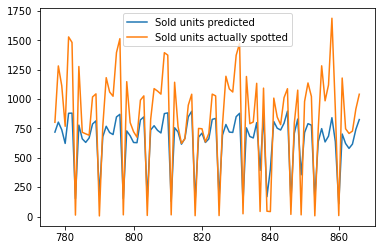

Predicción Modelo :GBR
Mean Error = 0.59546


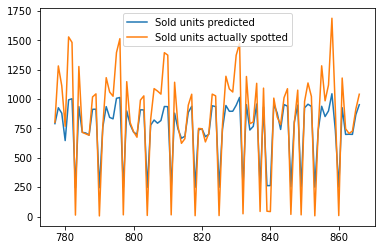

Predicción Modelo :RFR
Mean Error = 0.10292


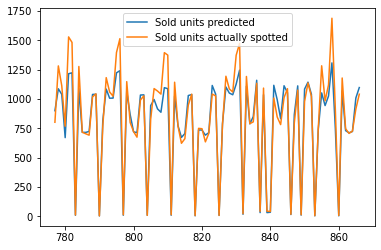

Predicción Modelo :KNR
Mean Error = 0.23207


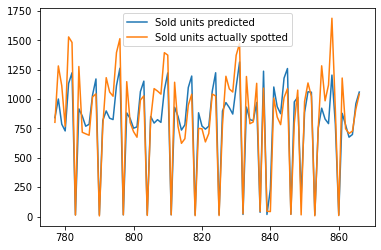

In [33]:
for index,model in enumerate(models):
    print('Predicción Modelo :'+model[0])
    calculoEvaluacionModelo(model[1],dataSku3,norma)


### Conclusión:

* Con la inclusión de estas nuevas variables se observa que seiguen mejorando los scores sobre todo con RFR - 0.10292 y KNR - 0.23207. 
* Aunque por contra esta el coste de computación de estos dos últimos modelos que es alto. Tarda mucho.
* He tenido que desistir de utilizar MLP con hiperparametros y variables sintéticas ya que tardaba muchimisimo.
* Por lo que ante la elección de un modelo u otro además de los scores más menos adecuados hay que pensar en la perfomance del modelo, es decir si por una ganacia mínima comprometemos en demasia tiempos de proceso.